In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP
from datasets import inputs, sf_inputs_discrete
import seaborn as sns
import pandas as pd

device = 'cpu'

/home/chingf/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")
/home/chingf/Code/sr-project/datasets/sf_inputs_discrete.py:14: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


# Examples of the four datasets used

In [2]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
def visualize_dset(dset, figname):
    num_states = dset.num_states
    arena_length = int(np.sqrt(num_states))
    fig, axs = plt.subplots(
        1, 2, gridspec_kw={'width_ratios': [1,2.75]}
        )
    
    # Plot sample inputs
    sample_inputs = dset.dg_inputs[:,:arena_length*3]
    divider = make_axes_locatable(axs[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = axs[0].imshow(sample_inputs)
    fig.colorbar(im, cax=cax, orientation='vertical')
    axs[0].set_xlabel('Timesteps')
    axs[0].set_ylabel('Input Neuron')
    axs[0].set_title('Activity')
    
    # Plot sample correlations
    feature_maker = dset.feature_maker
    feature_dim = feature_maker.feature_dim
    feature_map = feature_maker.feature_map # (features, states)
    feature_map = feature_map.reshape((arena_length, arena_length, feature_dim))
    test_x = 3
    test_y = 4
    test_state = test_x*arena_length + test_y
    xy_vec = feature_map[:,:,test_state].flatten()
    corr_mat = np.zeros((arena_length, arena_length))
    for i in range(arena_length):
        for j in range(arena_length):
            state = i*arena_length + j
            ij_vec = feature_map[:,:,state].flatten()
            corr_mat[i,j] = np.dot(xy_vec, ij_vec)
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = axs[1].imshow(corr_mat/feature_dim)
    fig.colorbar(im, cax=cax, orientation='vertical')
    axs[1].set_title("Sample Stimuli Correlation")
    axs[1].set_xlabel('X Location'); axs[1].set_xticks([])
    axs[1].set_ylabel('Y Location'); axs[1].set_yticks([])

    plt.suptitle("Dataset Visualization")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

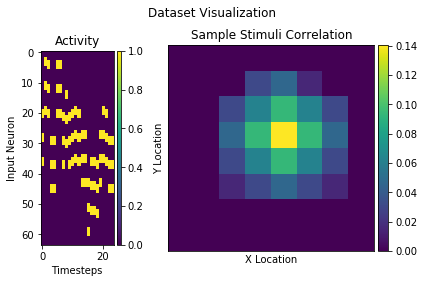

In [4]:
# Sparse and {0,1}
num_states = 64; arena_length = 8; feature_dim=64
feature_maker_kwargs = {
    'feature_dim': feature_dim, 'feature_type':'correlated_sparse',
    'feature_vals': [0,1], 'spatial_sigma': 1.25
    }
dset = sf_inputs_discrete.Sim2DLevyFlight(
    2000, walls=7, feature_maker_kwargs=feature_maker_kwargs
    )

visualize_dset(dset, None)

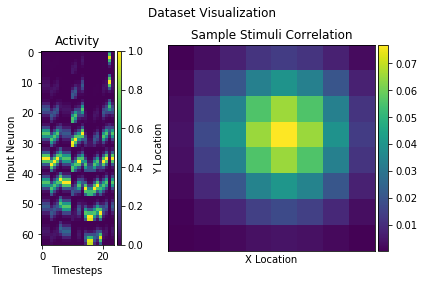

In [5]:
# Sparse and continuous
num_states = 64; arena_length = 8; feature_dim=64
feature_maker_kwargs = {
    'feature_dim': feature_dim, 'feature_type':'correlated_sparse',
    'feature_vals': None, 'spatial_sigma': 1.25
    }
dset = sf_inputs_discrete.Sim2DLevyFlight(
    2000, walls=7, feature_maker_kwargs=feature_maker_kwargs
    )

visualize_dset(dset, None)

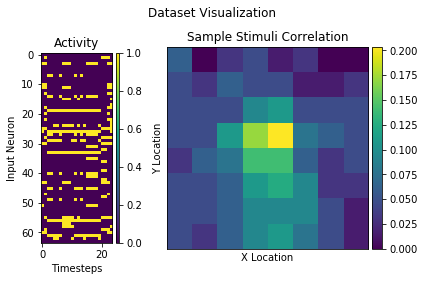

In [6]:
# Distributed and {0,1}
num_states = 64; arena_length = 8; feature_dim=64
feature_maker_kwargs = {
    'feature_dim': feature_dim, 'feature_type':'correlated_distributed',
    'feature_vals': [0,1], 'spatial_sigma': 1.25
    }
dset = sf_inputs_discrete.Sim2DLevyFlight(
    2000, walls=7, feature_maker_kwargs=feature_maker_kwargs
    )

visualize_dset(dset, None)

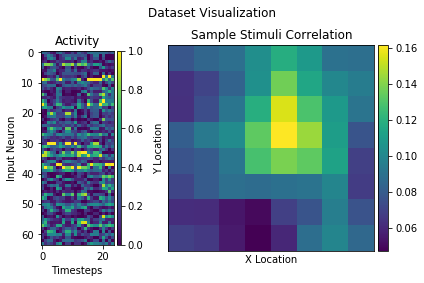

In [42]:
# Distributed and continuous
num_states = 64; arena_length = 8; feature_dim=64
feature_maker_kwargs = {
    'feature_dim': feature_dim, 'feature_type':'correlated_distributed',
    'feature_vals': None, 'spatial_sigma': 1.25
    }
dset = sf_inputs_discrete.Sim2DLevyFlight(
    2000, walls=7, feature_maker_kwargs=feature_maker_kwargs
    )

visualize_dset(dset, None)

# Plot TD Errors

In [13]:
def format_model_name(key):
    if key == 'rnn_dynamiclr':
        return 'RNN with Dynamic LR'
    elif key == 'rnn_fixedlr':
        return 'RNN with Fixed LR'
    elif key == 'linear':
        return 'Linear'
    elif key == 'mlp':
        return 'MLP with Replay Buffer'
    else:
        raise ValueError("Invalid key.")

In [38]:
def get_dset_ylim(key):
    if 'sparse_binary' in key:
        return [0.01, 0.04]
    elif 'contin' in key:
        return [0, 0.03]
    elif 'distrib_binary' in key:
        return [0.02, 0.05]
    else:
        raise ValueError("Invalid key.")

In [39]:
def plot(steps, losses, models, figname):
    df = pd.DataFrame({'Steps into Walk': steps, 'TD Error': losses, 'Model': models})
    fig, ax = plt.subplots(figsize=(2.75*2, 2*2)) # width, height default (6.4, 2.8)
    sns.lineplot(x='Steps into Walk', y='TD Error', hue='Model', data=df, ax=ax)
    plt.xlabel('') #'Steps into Walk', fontsize=14)
    plt.ylabel('') #'TD Error', fontsize=14)
    plt.title('') #format_dset_name(figname), fontsize=16)
    ylim = get_dset_ylim(figname)
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    plt.tight_layout()
    plt.savefig('td_discrete_corr_' + figname + '.png', dpi=100)
    plt.show()

distrib_binary


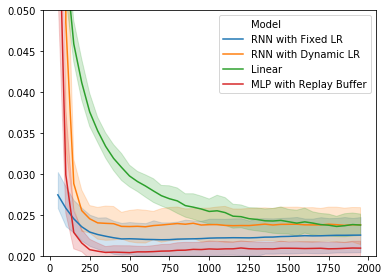

distrib_contin


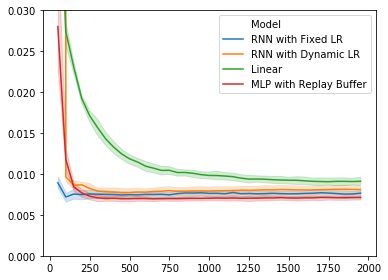

sparse_contin


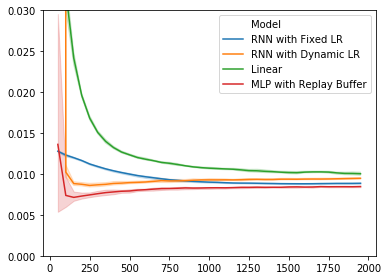

sparse_binary


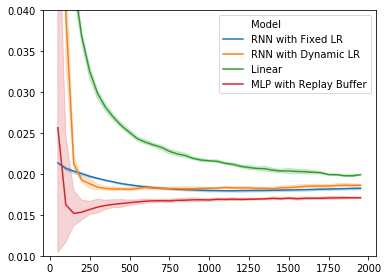

In [40]:
experiment_dir = "../trained_models/03_td_discrete_corr/"

for dset in os.listdir(experiment_dir):
    print(dset)
    dset_dir = experiment_dir + dset + '/'
    
    steps = []
    losses = []
    models = []
    for model in os.listdir(dset_dir):
        model_dir = dset_dir + model + '/'
        try:
            model_name = format_model_name(model)
        except:
            continue # Not a directory we care about
        for _iter in os.listdir(model_dir):
            iter_dir = model_dir + _iter + '/'
            for file in os.listdir(iter_dir):
                if 'tfevents' not in file: continue
                tfevents_file = iter_dir + '/' + file
                event_acc = EventAccumulator(tfevents_file)
                event_acc.Reload()
                scalar_events = event_acc.Scalars('loss_train')
                for i in range(len(scalar_events)):
                    steps.append(scalar_events[i].step)
                    losses.append(scalar_events[i].value)
                    models.append(model_name)
                break
    steps = np.array(steps)
    losses = np.array(losses)
    models = np.array(models)
    
    plot(steps, losses, models, dset)